# BigTable MTLM for LOA (Combined pf and n)
(Based on Cen 2009)
This model is used to explain the power law in learning.  In this notebook we try to build a neuralised version of the AFM and train it using simulated data.  The aim of using the AFM is to disentangle the latent traits that make up the overall score going into the sigmoid probability estimator.

The model is compensatory, which is a weakness.

In [22]:
from collections import defaultdict, Counter
from copy import copy
from math import exp, sqrt, log
from random import random, shuffle, choice, randint, uniform
import numpy
import math

from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.constraints import non_neg, max_norm
from numpy import array, ones, floor, ceil
from pandas import concat
from pandas import DataFrame
from keras.models import Sequential
from keras.layers import LSTM, multiply, subtract, add, Activation, Lambda, Flatten, maximum
from keras.layers import Dense, concatenate, MaxPooling1D, LocallyConnected1D, Reshape, Dropout
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras import constraints

import tensorflow as tf

from utils import generate_student_name
import random

from matplotlib import pyplot as plt

n_traits = 100


In [23]:
generate_student_name()

'PHUTHY CORE '

In [24]:
from keras import backend as K
from keras.constraints import Constraint
from keras.engine.topology import Layer
from keras import initializers

class WeightClip(Constraint):
    '''Clips the weights incident to each hidden unit to be inside a range
    '''
    def __init__(self, min_w=0, max_w=4):
        self.min_w = min_w
        self.max_w = max_w

    def __call__(self, p):
        return K.clip(p, self.min_w, self.max_w)

    def get_config(self):
        return {'name': self.__class__.__name__,
                'min_w': self.min_w,
                'max_w': self.max_w }


class ProductLayer(Layer):

    def __init__(self, output_dim, kernel_constraint=WeightClip(min_w=-4.0, max_w=4.0), minv=-4,maxv=4, **kwargs):
        
        self.output_dim = output_dim
        super(ProductLayer, self).__init__(**kwargs)
        self.kernel_constraint= constraints.get(kernel_constraint)
        self.min_v = minv
        self.max_v = maxv

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(1, self.output_dim),
                                      initializer=initializers.RandomUniform(minval=self.min_v,maxval=self.max_v),
#                                       initializer=initializers.Constant(value=2.0),
                                      trainable=True,
                                      constraint=self.kernel_constraint)
        
        super(ProductLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        p = x * self.kernel
        print("shape p", p.shape)
        return p

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    
class DifferenceLayer(Layer):

    def __init__(self, output_dim, kernel_constraint=WeightClip(min_w=-4.0, max_w=4.0), minv=-4,maxv=4, invert=False, **kwargs):
        
        self.output_dim = output_dim
        super(DifferenceLayer, self).__init__(**kwargs)
        self.kernel_constraint= constraints.get(kernel_constraint)
        self.min_v = minv
        self.max_v = maxv
        self.invert = invert

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        initialiser = initializers.RandomUniform(minval=self.min_v,maxval=self.max_v)
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(1, self.output_dim),
                                      initializer=initialiser,
#                                       initializer=initializers.Constant(value=2.0),
                                      trainable=True,
                                      constraint=self.kernel_constraint)
        super(DifferenceLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        if self.invert:
            x = tf.Print(x, [x], message="x is:", first_n=-1, summarize=1024)
            k = tf.Print(self.kernel, [self.kernel], message="- kernel is:", first_n=-1, summarize=1024)
            p = x - k
        else:
            k = tf.Print(self.kernel, [self.kernel], message="kernel is:", first_n=-1, summarize=1024)
            x = tf.Print(x, [x], message="- x is:", first_n=-1, summarize=1024)
            p = k - x
#         p = K.print_tensor(p, message="p is:")
        p =  tf.Print(p, [p], message="p is:", first_n=-1, summarize=1024)
        print("shape p", p.shape)
        return p

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [25]:
for z in [-20, -10, -4,-3,-2,-1,0,1,2,3,4]:
    print(z, 1/(1+exp(-z)) )

# q_p_avg = 0.45
run_p_easiest = 0.99
run_p_hardest = 0.01

# max_atts = 10
# q_p_easiest = (1-(1-run_p_easiest)**(1/10))
# q_p_hardest = (1-(1-run_p_hardest)**(1/10))
q_p_easiest = run_p_easiest
q_p_hardest = run_p_hardest

# print("hazards:")
# print(q_p_easiest, q_p_hardest)

pr_k_easiest = q_p_easiest**(1/n_traits)
pr_k_hardest = q_p_hardest**(1/n_traits)

inv_sigmoid = lambda pr : ( -log((1/pr) -1) )
easy_comp_del = inv_sigmoid(pr_k_easiest)
hard_comp_del = inv_sigmoid(pr_k_hardest)

offset = (easy_comp_del - hard_comp_del)/2
beta_min = 0
# beta_max = round(offset,1)
# theta_min = round(easy_comp_del - offset,1)
# theta_max = round(easy_comp_del,1)
beta_max = offset
theta_min = easy_comp_del - offset
theta_max = easy_comp_del


# beta_min = 0
# beta_max = 10
# theta_min = 5
# theta_max = 15

if theta_min < 0:
    beta_min -= theta_min
    beta_max -= theta_min
    theta_max -= theta_min
    theta_min -= theta_min


print("bs:",beta_min, beta_max)
print("ths:", theta_min, theta_max)

worst_comp_pr = 1/(1+exp(-(theta_min - beta_max)))
best_comp_pr = 1/(1+exp(-(theta_max - beta_min)))

print("worst cmp chance=", worst_comp_pr)
print("best cmp chance=", best_comp_pr)

print("worst Pr=", worst_comp_pr**n_traits)
print("best Pr=", best_comp_pr**n_traits)

# print("worst Run Pr=", 1-(1-(worst_comp_pr**n_traits))**max_atts)
# print("best Run Pr=", 1-(1-(best_comp_pr**n_traits))**max_atts)


nom = array([
    [1,2,3],
    [4,5,6],
    [7,8,9],
])

sel = nom[[0,2]]
print(sel)
print(sel.shape)


-20 2.0611536181902037e-09
-10 4.5397868702434395e-05
-4 0.01798620996209156
-3 0.04742587317756678
-2 0.11920292202211755
-1 0.2689414213699951
0 0.5
1 0.7310585786300049
2 0.8807970779778823
3 0.9525741268224334
4 0.9820137900379085
bs: 0 3.075196407410573
ths: 6.130072753253939 9.205269160664512
worst cmp chance= 0.9549925860214361
best cmp chance= 0.9998995016917583
worst Pr= 0.010000000000000165
best Pr= 0.9900000000000009
[[1 2 3]
 [7 8 9]]
(2, 3)


In [26]:
class BigTable(Layer):

    def __init__(self, _dim, min_w=0, max_w=10, **kwargs):
        self.dim = _dim
        self.limits = (min_w, max_w)
        kc =WeightClip(min_w, max_w)
        self.kernel_constraint= constraints.get(kc)
        super(BigTable, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        min_w, max_w = self.limits
        av_w = (min_w + max_w)/2.0
        initialiser = initializers.RandomUniform(min_w, max_w)
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(self.dim),
                                      initializer=initialiser,
                                      trainable=True,
                                      constraint=self.kernel_constraint)
        print("kk", self.kernel.shape)
        super(BigTable, self).build(input_shape)  # Be sure to call this at the end

    def call(self, selector):
        print("selector shape", selector.shape)
        selector = K.flatten(selector)
        print("flat selector shape", selector.shape)
        print("call kk", self.kernel.shape)
#         selector = tf.Print(selector, [selector], message="selector is:", first_n=-1, summarize=1024)

        rows = K.gather(self.kernel, selector)
#         rows = tf.Print(rows, [rows], message="row is:", first_n=-1, summarize=1024)
        print("'rows' shape,",rows.shape)
        return rows

    def compute_output_shape(self, input_shape):
        return ((None, self.dim[1]))


In [27]:
class Question():
    def __init__(self, qix, min_diff, max_diff, nt=None, nnw=None, optimiser=None):
        #self.MAX_BETA = 15
        mass = random.uniform(min_diff*nt,max_diff*nt)
#         mass = random.choice([(0.8*min_diff+0.2*max_diff)*nt, 0.5*(min_diff+max_diff)*nt, (0.2*min_diff + 0.8*max_diff)*nt])
        base = min_diff*nt
        mass = mass - base
        
        self.id = qix
#         no_dummies = randint(1,(nt-1))
        no_live = nt
#         print("no_dummies=",no_dummies)
#         self.betas = [ round(random.uniform(min_diff, max_diff),1) for _ in range(nt) ]

        not_present= min_diff
        self.betas = [ not_present for _ in range(nt) ]
        choices = list(range(nt))
        shuffle(choices)
        while mass > 0:
            for c in choices:
                curr = self.betas[c]
                if curr >= max_diff:
                    continue
                slyce = min(random.uniform(0,max_diff-curr), mass)
                mass -= slyce
                self.betas[c] += slyce
                if mass <= 0:
                    break            

In [28]:
class Student():
    def __init__(self, psix, min_abil, max_abil, nt=None, nnw=None, optimiser=None):
        #self.MAX_BETA = 15
        mass = random.uniform(min_abil*nt,max_abil*nt)
        base = min_abil*nt
        mass = mass - base
        
        self.id = psix
        self.name = generate_student_name()
#         min_abil = 0
#         max_abil = 10
#         self.thetas = [ round(random.uniform(min_abil, max_abil),1) for _ in range(nt) ]
        not_present= min_abil
        self.thetas = [ not_present for _ in range(nt) ]
        choices = list(range(nt))
        shuffle(choices)
        while mass > 0:
            for c in choices:
                curr = self.thetas[c]
                if curr >= max_abil:
                    continue
                slyce = min(random.uniform(0,max_abil-curr), mass)
                mass -= slyce
                self.thetas[c] += slyce
                if mass <= 0:
                    break                  
    

In [29]:
def attempt_q(student: Student, q: Question):
    p = calculate_pass_probability(student.thetas, q.betas)
    this_att = uniform(0,1)
    if (this_att <= p):
        passed=1
#         print("passed")
#         student.mastery[q.id] = 1
    else:
        passed=0

    return p,passed

In [30]:
def calculate_pass_probability(thetas, betas):
    # additive factors model is:
    # p_pass = 1 / 1 + exp(-z)
    # where z = a + sum[1:n]( -b + gT )
    
    p_pass = 1.0
#     print("th,b",thetas,betas)
    for th,b in zip(thetas,betas):
        z = (th-b)
        p_pass_step = exp(z) / (1.0 + exp(z))
#         print(th,"vs",b,"->",z,": ", p_pass_step)
        p_pass *= p_pass_step # simple conjunctive model of success!
    try:
        pass
#         print("p_pass={}".format(p_pass))
    except OverflowError:
        p_pass = 0.0
#     print("real p_pass = {}".format(p_pass))
    return p_pass
    

In [31]:
qopt = Adam()

def create_qs(n_qs, nt=n_traits, nnw=n_traits, optimiser=qopt):
    random.seed(666)
    master_qs = [Question(qix, beta_min,beta_max, nt=nt, nnw=nnw, optimiser=optimiser) for qix in range(n_qs)]
    for q in master_qs:
        nocomps = len(q.betas)
#         mag = sqrt(sum([ pow(b, 2) for b in q.betas if b!=-10 ]))
        mag = sum(q.betas)
        print("Q:{}, difficulty={:.2f} across {} components".format(q.id, mag, nocomps))
    
    for q in master_qs:
        print("qid",q.id,q.betas)
    
    qn_table = BigTable((n_qs, nnw),min_w=beta_min, max_w=beta_max)
    
    return master_qs, qn_table

# Training
This is where sh!t gets real.  We take our tr_len (1000?) students, and iterate over them 100 times to create 100,000 *complete examples* of a student attacking the curriculum.  The questions themselves are attacked in random order: the student has no intelligent guidance throught the material. (Obvious we may wish to provide that guidance at some point in the future.)

Remember, there are only 12 exercises in the curriculum, so if the student is taking 60 or 70 goes to answer them all, that's pretty poor.  But some of these kids are dumb as lumber, so cut them some slack!  They will all get there in the end since by the CMU AFM practice will, eventually, make perfect!

In [32]:
psi_opt = Adam()
def create_students(n_students, nt=n_traits, nnw=n_traits, optimiser=None):
    random.seed(666)
    psi_list = [ Student(psix, theta_min,theta_max, nt=nt, nnw=nnw, optimiser=optimiser) for psix in range(n_students)]
    for psi in psi_list:
        print(psi.name, psi.thetas)
        
    psi_table = BigTable((n_students, nnw), min_w=theta_min, max_w=theta_max)
    psi_attn_table = BigTable((n_students, 1), min_w=0, max_w=1)
    print("psi_table wgts", psi_table.get_weights())
    
    return psi_list, psi_table
    

In [33]:
extend_pop=False
extend_by = 90
if extend_pop:
    for _ in range(extend_by):
        nu_psi = Student(nt=n_traits, nq=len(master_qs), optimiser=psi_opt)
        psi_list.append(nu_psi)

In [34]:
import gc
def generate_attempts(master_qs, psi_list):
    attempts =[]
    attempts_by_q = {}
    attempts_by_psi = {}
    attempt_n_map = Counter()

    user_budget = math.inf
    user_patience = 10
    pass_to_remove = True
    for run in range(1):
        print("----{}\n".format(run))
        for psi in psi_list:
            spend=0
            #psi.mastery = [0 for _ in range(nq)]
            qs = [ix for ix in range(len(master_qs))]
#             print("* * * **** USER {}".format(psi.name))
#             print("* * * * ** THETAS {}".format(psi.thetas))

            while(True):
                q_ct = 0
                qix = random.choice(qs)
                q = master_qs[qix]
                passed=0

                if psi.name not in attempts_by_psi:
                    attempts_by_psi[psi.name]=[]

                if q not in attempts_by_q:
                    attempts_by_q[q]=[]

                while q_ct<user_patience:
                    q_ct+=1
                    pp,passed = attempt_q(psi, q)
                    tup = (psi.id, q.id, passed, (q_ct if passed else 0))
                    attempts.append(tup)
                    attempt_n_map[(q.id,psi.id)] += 1
                    if passed:
                        break
                
                print("p_pass was",pp) #, "run p:", 1-(1-pp)**max_atts)
                
                attempts_by_psi[psi.name].append(tup)
                attempts_by_q[q].append(tup)
                                        
                if passed:
                    print("passed in",q_ct)
                    qs.remove(qix)

                spend += q_ct

                if qs == [] or spend>=user_budget:
                    break
    gc.collect()
    return attempts, attempts_by_q, attempts_by_psi, attempt_n_map


def generate_qs_model(qn_table, psi_table, optimiser):
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    did_pass = Input(shape=(1,), name="did_pass")
#     did_n = Input(shape=(1,), name="did_n")
    print(qn_table, psi_table, psi_sel, qn_sel)
    print("psi_sel shape", psi_sel.shape)

    psi_table.trainable=True
    qn_table.trainable=True
    
    qn_row = qn_table(qn_sel)
    psi_row = psi_table(psi_sel)
    dif = subtract([psi_row, qn_row])
    print("dif",dif.shape)
    Prs = Lambda(lambda z: K.exp(z) / (1.0 + K.exp(z)), name="sPr_sigmoid")(dif)
    
    print("Prs",Prs.shape)
    #calculate the hazard rate here
    hz = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="sPr_prod")(Prs)
#     print("hz",hz.shape)
    
#     max_att = 10
    #calculate the prob of passing in <= max_att
    #prob of passing at point t:
    #Pr(X=t) = (1-p)^(t-1) * p # i.e. fail^(t-1), then pass 
    
#     Pr = (1-p)^(t-1) * p
    
    
#     hidden = Dense(5, activation="relu")(Prs)
#     hidden = Dense(5, activation="relu")(hidden)
#     hidden = Dense(5, activation="relu")(hidden)
#     n = Dense(1, activation="relu")(hidden)
    n = Lambda(lambda p: (1/p), name="n_calc")(hz)
#     print("n",n.shape)
    n = multiply([n, did_pass], name="n_cancellor")

#     print("did_pass", did_pass.shape)
    print("n'",n.shape)

#     hz = Lambda(lambda hz: tf.Print(hz, [hz], message="hz is:", first_n=-1, summarize=1024))(hz)
#     pazz = Lambda( lambda p : (1.0-K.pow((1-p),max_att)), name="pazz_calc" ) (hz)
#     pazz = Lambda(lambda t: tf.Print(t, [t], message="pazz is:", first_n=-1, summarize=1024))(pazz)

#     hidden2 = Dense(5, activation="relu")(Prs)
#     hidden2 = Dense(5, activation="relu")(hidden2)
#     hidden2 = Dense(5, activation="relu")(hidden2)
#     pazz = Dense(1, activation="sigmoid")(hidden2)
#     print("pazz",pazz.shape)
    
    model = Model(inputs=[qn_sel, psi_sel, did_pass], outputs=[hz,n])
#     model = Model(inputs=[qn_sel, psi_sel], outputs=[n,])
    model.compile(optimizer=optimiser, loss=["binary_crossentropy","mse"], loss_weights=[1.0,1.0])
    return model

In [35]:
def init_weights(master_qs, psi_list, attempts_by_psi, attempts_by_q, q_table, s_table, min_b, max_b, min_th, max_th):
    numpy.random.seed(666)
    psi_wgts = s_table.get_weights()[0]
    for s in psi_list:
#         attz = [tup[2] for tup in attempts_by_psi[s.name]]
#         prop = mean(attz)
#         p = prop**(1/n_traits)
#         cw_prop = log(p / (1-p))
        av_th = (min_th + max_th)/2.0
#         psi_wgts[s.id,:] = numpy.random.uniform(max_th-1, max_th, size=psi_wgts.shape[1])
        psi_wgts[s.id,:] = numpy.random.uniform(min_th, max_th, size=psi_wgts.shape[1])

        print(psi_wgts[s.id,:])
    s_table.set_weights([ psi_wgts ])

    qn_wgts = q_table.get_weights()[0]
    for q in master_qs:
#         attz = [tup[2] for tup in attempts_by_q[q]]
#         prop = mean(attz)
#         p = prop**(1/n_traits)
#         cw_prop = log((1-p) / p)
        av_b = (min_b + max_b)/2.0
#         qn_wgts[q.id,:]= numpy.random.uniform(min_b, min_b+1, size=qn_wgts.shape[1])
        qn_wgts[q.id,:]= numpy.random.uniform(min_b, max_b, size=qn_wgts.shape[1])

        print(qn_wgts[q.id,:])
    q_table.set_weights([ qn_wgts ])
    

In [36]:
def calc_arr_arr_err(real_wgts, pred_wgts, max_iter=10):
    from scipy.spatial.distance import cosine
# pred_wgts = numpy.round(pred_wgts,1)

    out_cols = [None] * len(real_wgts.T)
    curr_sel = None
    curr_ix = None
    n_iters = 10
    chosen = None

    indices = range(len(real_wgts.T))

    min_total_err = math.inf
    best_cos_dis = math.inf
    for i in range(max_iter): #len(indices)**2):
        real_used = set()
        pred_used = set()
        while len(pred_used) < len(indices):
            curr_err = math.inf
            curr_cos = math.inf
            for rix in numpy.random.permutation(indices):
                if rix in real_used:
                    continue
                real_col = real_wgts.T[rix]
                for cix in numpy.random.permutation(indices):
                    if cix in pred_used:
                        continue
                    pred_col = pred_wgts.T[cix]
                    err = numpy.mean(numpy.abs( pred_col - real_col))
                    #print("mae is ",mse)
                    if err < curr_err:
    #                     print("best match", cix, rix)
    #                     print(real_col)
    #                     print(pred_col)
                        curr_sel = pred_col
                        curr_err = err
                        curr_cos = cosine(pred_col, real_col)
                        curr_ix = cix
                        curr_real_ix = rix
    #         print("---")
            real_used.add(curr_real_ix)
            pred_used.add(curr_ix)
            out_cols[curr_real_ix] = curr_sel
        out_col_arr = array(out_cols).T
        total_err = numpy.mean(numpy.abs( out_col_arr - real_wgts ))
        cos_dis = cosine(out_col_arr.flatten(), real_wgts.flatten())
        mean_ll = numpy.mean( out_col_arr - real_wgts )
#         if total_err < min_total_err:
        if cos_dis < best_cos_dis:
            min_total_err = total_err
            best_ll = mean_ll
            chosen = out_col_arr
            best_cos_dis = cos_dis
#             print("new total min mae:", min_total_err)
#             print("new best ll", best_ll)
    return chosen, min_total_err, mean_ll, best_cos_dis

In [37]:
import os
import IPython

def calibrate(master_qs, psi_list, qs_model, q_model, s_model, attempts, attempts_by_psi, attempts_by_q, attempt_n_map, s_table, q_table, n_iter=20, record_param_fit=False):
    es = EarlyStopping(monitor="val_loss", mode="auto", patience=0)
    random.seed(666)
    min_mse = 1000
    min_avg_fit_rmse = math.inf
    min_loss= math.inf
    q_outer_mses = []
    q_outer_accs = []
    s_outer_mses = []
    s_outer_accs = []
    th_mses = []
    b_mses = []
    th_accs= []
    b_accs =[]
    h= []
    avg_fit_rmses = []
    th_fit_rmses = []
    b_fit_rmses = []
    init_patience = 20
    patience = init_patience

    print(attempts[0:100])

    qices = array([int(tup[1]) for tup in attempts]).flatten() #reshape(-1,1)
    psices = array([int(tup[0]) for tup in attempts]).flatten() #reshape(-1,1)
    pfs = array([tup[2] for tup in attempts]).flatten() #reshape(-1,1)
    #ns = array([tup[3] for tup in attempts]).flatten() #reshape(-1,1)
    ns =array( [(attempt_n_map[(q,p)] if pf>0 else 0)  for (q,p,pf) in zip(qices, psices, pfs) ])
    len_all = qices.shape[0]
        
    qz = qices
    sz = psices
    pfz = pfs
    nz = ns

#     for pf in pfs:
#         print(pf)
    
    print(qz)
    print(sz)
    print(pfz)
    print(nz)
#     input("Xsan")
    
    loss = False
    mse = False
    acc = False
    early_stop = True
    min_stop = 0
#     n_iter = 1
    for i in range(n_iter):
#         shuffle(attempts)
#         attemptz = attempts[0:100]
#         qices = array([int(tup[1]) for tup in attemptz]).flatten() #reshape(-1,1)
#         psices = array([int(tup[0]) for tup in attemptz]).flatten() #reshape(-1,1)
#         pfs = array([tup[2] for tup in attemptz]).flatten() #reshape(-1,1)
#         len_all = qices.shape[0]      

#         qz = qices
#         sz = psices
#         pfz = pfs
        
#         psi = random.choice(psi_list)
#         q = random.choice(qs)
#         print(psi.id, psi.name, q.id)
#     while True:
#         numpy.random.shuffle(attempts)
        base_ix = 0
        done = False
#         for j in range(chunkz+1):
        j = 0
        sub_h = []
        
        qs_model.train_on_batch(x=[qz, sz, pfz], y=[pfz,nz])#, epochs=10, shuffle=True, batch_size=1, callbacks=[es])

        if i % 10 == 0:
            topn=20
            pred_pfz, pred_nz = qs_model.predict(x=[qices[0:topn], psices[0:topn], pfs[0:topn]], verbose=0) 
            for j in range(topn):
                print(qices[j], psices[j], pfs[j], ns[j], ":", pred_pfz[j], pred_nz[j])

            tup = qs_model.evaluate(x=[qices, psices, pfs], y=[pfs,ns], verbose=0) #, epochs=1, shuffle=True, batch_size=1, verbose=0) #, callbacks=[es])
#             loss2, mse2, acc2 = s_model.evaluate(x=[qices, psices], y=pfs, verbose=0) #, epochs=1, shuffle=True, batch_size=1, verbose=0) #, callbacks=[es])
#             loss=(loss+loss2)/2
#             mse=(mse+mse2)/2
#             acc=(acc+acc2)/2
            comb_loss, cat_loss, mse = tup
            tup = comb_loss, cat_loss, mse, acc
            sub_h.append(tup)

            psi_wgts = s_table.get_weights()[0]
            th_rmses = []
            for s in psi_list:
                s_thetas = numpy.sort(s.thetas)
                s_wgts = numpy.sort(psi_wgts[s.id])
                err = numpy.mean( numpy.abs(s_thetas - s_wgts) )
#                 err = cosine(s_thetas, s_wgts)
                th_rmses.append(err)

            qn_wgts = q_table.get_weights()[0]
            b_rmses = []
            for q in master_qs:
                q_betas = numpy.sort(q.betas)
                q_wgts = numpy.sort(qn_wgts[q.id])
                err = numpy.mean( numpy.abs(q_betas - q_wgts) )
#                 err = cosine(q_betas, q_wgts)
                b_rmses.append(err)
            
            print("i =",i)
            th_rmse = numpy.mean(th_rmses)
            th_fit_rmses.append(th_rmse)
            print("th RMSE=", th_rmse)
            b_rmse = numpy.mean(b_rmses)
            b_fit_rmses.append(b_rmse)
            print("b RMSE=", b_rmse)
#             print(loss,pf_loss,mse,acc, n_acc)
            print(mse,acc)
            sub_h = numpy.array(sub_h)
            sub_tup = (sub_h[-1,0],sub_h[-1,1],sub_h[-1,2],sub_h[-1,3])
            h.append(sub_tup)
#             av_rmse = (th_rmse/len(psi_list) +b_rmse/len(master_qs))
#             av_rmse =(th_rmse+b_rmse)/2.0
            av_rmse = b_rmse
            print("av RMSE=",av_rmse)
            if av_rmse < min_avg_fit_rmse:
                patience = init_patience
                print("patience reset to", init_patience)
                min_avg_fit_rmse = av_rmse
                min_loss = loss
                qs_model.save_weights("qs_best_weights_LOA_combined.hdf5")
                print("...model saved")
            else:
                if early_stop and i>min_stop:
#                 if loss < min_loss:
#                     print(loss,"<",min_loss)
                    if patience >0:
                        patience -= 1
                        print("patience now", patience)
                    else:
                        print("Earlying stoppin' @",i)
                        break

    #     del h
    #     loss, mse, acc = qs_model.evaluate(x=[qices, psices], y=pfs)

    #     print(loss, mse, acc)
    return h, th_fit_rmses, b_fit_rmses


In [38]:
nn_dimensions = [n_traits]
serieses = []
min_errs = []
n_qs = 30
n_students = 100
opt = Adam() #try 0.5 for 2 dim

for ix,nnw in enumerate(nn_dimensions):
    qs, q_table = create_qs(n_qs, n_traits, nnw, optimiser=opt)
    ss, s_table = create_students(n_students, n_traits, nnw, optimiser=opt)
    attempts, attempts_by_q, attempts_by_psi, attempt_n_map = generate_attempts(qs,ss)
    
    pf = [tup[2] for tup in attempts]
    N = len(pf)
    pN = sum(pf)
    pr = pN/N
    
#     print(attempts)
#     q_model = generate_model(q_table, s_table, opt, mode="q_train")
#     s_model = generate_model(q_table, s_table, opt, mode="s_train")
    q_model = None
    s_model = None
    qs_model = generate_qs_model(q_table, s_table, opt)
#     qs_model = None
#     psi_model = generate_psi_model(s_table, qopt)
    init_weights(qs, ss, attempts_by_psi, attempts_by_q, q_table, s_table, beta_min, beta_max, theta_min, theta_max)
#     input("chunt")    psi_wgts = s_table.get_weights()[0]
#     qn_wgts = q_table.get_weights()[0]

#     print("pass rate is {} of {} = {}".format(pN,N,pr))
#     for _ in range(10):
#         print("*")
#     input("yam")


    h, th_fit_rmses, b_fit_rmses = calibrate(qs,ss, qs_model, q_model, s_model, attempts, attempts_by_psi, attempts_by_q, attempt_n_map, s_table, q_table, n_iter=1000000, record_param_fit=True)
    qs_model.load_weights("qs_best_weights_LOA_combined.hdf5")

    

Q:0, difficulty=140.27 across 100 components
Q:1, difficulty=55.19 across 100 components
Q:2, difficulty=274.33 across 100 components
Q:3, difficulty=139.72 across 100 components
Q:4, difficulty=1.22 across 100 components
Q:5, difficulty=268.60 across 100 components
Q:6, difficulty=203.38 across 100 components
Q:7, difficulty=189.53 across 100 components
Q:8, difficulty=288.47 across 100 components
Q:9, difficulty=240.33 across 100 components
Q:10, difficulty=47.19 across 100 components
Q:11, difficulty=111.30 across 100 components
Q:12, difficulty=304.21 across 100 components
Q:13, difficulty=272.63 across 100 components
Q:14, difficulty=195.55 across 100 components
Q:15, difficulty=193.69 across 100 components
Q:16, difficulty=22.15 across 100 components
Q:17, difficulty=66.40 across 100 components
Q:18, difficulty=71.47 across 100 components
Q:19, difficulty=233.20 across 100 components
Q:20, difficulty=253.38 across 100 components
Q:21, difficulty=71.10 across 100 components
Q:22, 

p_pass was 0.38175979251614034
passed in 4
p_pass was 0.8136052660412637
passed in 1
p_pass was 0.48524257484822625
passed in 1
p_pass was 0.927803711720998
passed in 1
p_pass was 0.8208885744753495
passed in 3
p_pass was 0.5676001899877009
passed in 1
p_pass was 0.8180287546425382
passed in 1
p_pass was 0.5904132019012894
passed in 1
p_pass was 0.766208375554337
passed in 2
p_pass was 0.41511606020715147
passed in 4
p_pass was 0.28349926277492227
passed in 1
p_pass was 0.4879455148443219
passed in 1
p_pass was 0.535502184261403
passed in 2
p_pass was 0.8722265838841704
passed in 1
p_pass was 0.28788949551609855
passed in 1
p_pass was 0.3819064614995498
passed in 2
p_pass was 0.3690722633766196
passed in 1
p_pass was 0.44165110834706184
passed in 1
p_pass was 0.8105714717731649
passed in 2
p_pass was 0.6732876478621465
passed in 1
p_pass was 0.6912172948970782
passed in 1
p_pass was 0.8221303995123829
passed in 1
p_pass was 0.5137733574235227
passed in 3
p_pass was 0.6603340601669049
p

p_pass was 0.6955748085420154
passed in 2
p_pass was 0.3366588447159863
passed in 2
p_pass was 0.42131213467614953
passed in 2
p_pass was 0.5315490282818554
passed in 5
p_pass was 0.7583303801948036
passed in 1
p_pass was 0.35718266701935136
passed in 2
p_pass was 0.12269439141765358
p_pass was 0.5365100266982036
passed in 3
p_pass was 0.2010316635564541
passed in 1
p_pass was 0.10776322674362793
p_pass was 0.059113459332972906
passed in 5
p_pass was 0.11193874151464915
p_pass was 0.8323713751481264
passed in 1
p_pass was 0.14988508744412596
p_pass was 0.03917001789223562
passed in 6
p_pass was 0.1623068955050045
p_pass was 0.11193874151464915
passed in 2
p_pass was 0.08058523347280985
p_pass was 0.19603173539502167
passed in 1
p_pass was 0.5443110470415526
passed in 5
p_pass was 0.10776322674362793
passed in 6
p_pass was 0.581984265702731
passed in 2
p_pass was 0.05329790143871487
passed in 3
p_pass was 0.02590510211829575
p_pass was 0.1623068955050045
passed in 3
p_pass was 0.0805852

p_pass was 0.1991943854061914
passed in 4
p_pass was 0.1984811914904051
passed in 1
p_pass was 0.19492936017562607
passed in 2
p_pass was 0.1224772898343763
passed in 7
p_pass was 0.6434658681305025
passed in 2
p_pass was 0.5883127643971852
passed in 2
p_pass was 0.07075960946663357
p_pass was 0.8754746097188449
passed in 1
p_pass was 0.6548434598643673
passed in 2
p_pass was 0.2640200040380966
passed in 1
p_pass was 0.4595542687019622
passed in 1
p_pass was 0.4752520671810326
passed in 2
p_pass was 0.4906739648512423
passed in 1
p_pass was 0.18082753998640122
passed in 2
p_pass was 0.10031511553105851
passed in 4
p_pass was 0.28403432554934077
passed in 5
p_pass was 0.4486586001299303
passed in 1
p_pass was 0.6196987503666689
passed in 1
p_pass was 0.1429142089534437
p_pass was 0.7691830364852303
passed in 2
p_pass was 0.07487571082694919
p_pass was 0.7171379102754756
passed in 1
p_pass was 0.07487571082694919
p_pass was 0.11851091782371222
passed in 4
p_pass was 0.831682414136063
pas

p_pass was 0.7244578167857039
passed in 1
p_pass was 0.5037961739530668
passed in 6
p_pass was 0.9101297520546006
passed in 1
p_pass was 0.7581745045951822
passed in 1
p_pass was 0.9525714384346612
passed in 1
p_pass was 0.9639561544684778
passed in 1
p_pass was 0.8994196834302337
passed in 1
p_pass was 0.0947317914921661
p_pass was 0.6342066251725298
passed in 1
p_pass was 0.1868055398698091
p_pass was 0.06362947471188347
p_pass was 0.39806526369621714
passed in 2
p_pass was 0.0947317914921661
p_pass was 0.5056052297527204
passed in 5
p_pass was 0.04496867282080702
p_pass was 0.20034506913683706
passed in 2
p_pass was 0.17073254095226267
passed in 8
p_pass was 0.2105466615671965
passed in 6
p_pass was 0.5569904789646617
passed in 1
p_pass was 0.5248633562322851
passed in 2
p_pass was 0.04496867282080702
p_pass was 0.3090159607608257
passed in 5
p_pass was 0.8390914836950861
passed in 2
p_pass was 0.1868055398698091
passed in 3
p_pass was 0.06362947471188347
p_pass was 0.06558827803507

p_pass was 0.012369325231383656
passed in 3
p_pass was 0.5629654491128799
passed in 1
p_pass was 0.030304581251316284
p_pass was 0.34690789305676445
passed in 2
p_pass was 0.05005232066976761
p_pass was 0.03470567205078852
passed in 1
p_pass was 0.020990593253921788
passed in 4
p_pass was 0.012943036143114891
p_pass was 0.05005232066976761
p_pass was 0.2761767334666481
passed in 5
p_pass was 0.012943036143114891
p_pass was 0.07642258997615013
passed in 8
p_pass was 0.11138204813833137
passed in 10
p_pass was 0.2875000749201535
passed in 4
p_pass was 0.04933791453062814
passed in 2
p_pass was 0.030304581251316284
p_pass was 0.07157889701326049
p_pass was 0.07157889701326049
p_pass was 0.1299116584957873
p_pass was 0.07157889701326049
p_pass was 0.05005232066976761
passed in 1
p_pass was 0.012943036143114891
p_pass was 0.030304581251316284
passed in 1
p_pass was 0.1299116584957873
p_pass was 0.07157889701326049
p_pass was 0.07157889701326049
passed in 2
p_pass was 0.1299116584957873
pass

p_pass was 0.7416756608776787
passed in 1
p_pass was 0.4347827833611565
passed in 5
p_pass was 0.8145731214590233
passed in 1
p_pass was 0.9497357536833069
passed in 1
p_pass was 0.5740969714884776
passed in 1
p_pass was 0.7937959560484581
passed in 1
p_pass was 0.8342375682228294
passed in 1
p_pass was 0.3421793854399133
passed in 2
p_pass was 0.8717913345258584
passed in 1
p_pass was 0.43835523023260625
passed in 4
p_pass was 0.9082813619492626
passed in 1
p_pass was 0.716027074928325
passed in 1
p_pass was 0.8960832610022482
passed in 2
p_pass was 0.8378175319666229
passed in 1
p_pass was 0.6209128813983962
passed in 1
p_pass was 0.535146496287592
passed in 1
p_pass was 0.5490528289085941
passed in 2
p_pass was 0.8167526279744615
passed in 1
p_pass was 0.34986138538525996
passed in 4
p_pass was 0.8045431365617827
passed in 2
p_pass was 0.5474713143875278
passed in 1
p_pass was 0.7030082132862885
passed in 1
p_pass was 0.5842211206406296
passed in 4
p_pass was 0.4243930994124391
pass

passed in 3
p_pass was 0.4255127214251256
passed in 2
p_pass was 0.47590636821213894
passed in 1
p_pass was 0.8246714586868233
passed in 2
p_pass was 0.7880793620501124
passed in 1
p_pass was 0.6388405382880025
passed in 1
p_pass was 0.7761665988108757
passed in 1
p_pass was 0.7963392751517153
passed in 1
p_pass was 0.455957660991991
passed in 1
p_pass was 0.5648087149308685
passed in 1
p_pass was 0.7956335308771842
passed in 1
p_pass was 0.59049141138958
passed in 6
p_pass was 0.4675025905620208
passed in 9
p_pass was 0.7472434945942045
passed in 1
p_pass was 0.6129851452676557
passed in 1
p_pass was 0.4020989931265566
passed in 4
p_pass was 0.9085174068039601
passed in 1
p_pass was 0.7080647765294101
passed in 1
p_pass was 0.44397723343164697
passed in 2
p_pass was 0.8835180373848902
passed in 1
p_pass was 0.7559001827475976
passed in 1
p_pass was 0.9380531043212478
passed in 1
p_pass was 0.27294647024970137
passed in 10
p_pass was 0.31564663587256525
passed in 2
p_pass was 0.8427657

passed in 1
p_pass was 0.7670356578892275
passed in 2
p_pass was 0.8726613798943033
passed in 1
p_pass was 0.5902246070794083
passed in 2
p_pass was 0.5105715313716731
passed in 4
p_pass was 0.9383640820975558
passed in 1
p_pass was 0.871858349630916
passed in 1
p_pass was 0.40396371826376537
passed in 1
p_pass was 0.954336630466453
passed in 1
p_pass was 0.4416450313399911
passed in 1
p_pass was 0.8166608630863499
passed in 1
p_pass was 0.6725056147307172
passed in 1
p_pass was 0.4953824004510575
passed in 2
p_pass was 0.8391964531520064
passed in 1
p_pass was 0.6806371683346738
passed in 1
p_pass was 0.7690359275168561
passed in 1
p_pass was 0.5865265581045898
passed in 2
p_pass was 0.40076632944692786
passed in 3
p_pass was 0.8508873729201994
passed in 1
p_pass was 0.6136569294846618
passed in 1
p_pass was 0.8450447372592889
passed in 1
p_pass was 0.6478701177447566
passed in 2
p_pass was 0.55009845283242
passed in 2
p_pass was 0.8592329228989392
passed in 1
p_pass was 0.49289858319

p_pass was 0.11264311525543648
passed in 7
p_pass was 0.11929184177258607
passed in 7
p_pass was 0.6383100682174341
passed in 1
p_pass was 0.645830254167576
passed in 1
p_pass was 0.24424712895525535
passed in 2
p_pass was 0.5554746747198145
passed in 1
p_pass was 0.8756523275293921
passed in 1
p_pass was 0.06677385222780245
p_pass was 0.06677385222780245
passed in 6
p_pass was 0.2854832482070109
passed in 7
p_pass was 0.34035538368741536
passed in 3
p_pass was 0.2921149710676053
passed in 3
p_pass was 0.18353240988173322
p_pass was 0.5078925742655479
passed in 1
p_pass was 0.06022250484602859
p_pass was 0.01910373353690116
passed in 1
p_pass was 0.03033521482399943
passed in 7
p_pass was 0.044697752081048106
p_pass was 0.06643283946774906
passed in 7
p_pass was 0.1390153800583157
passed in 2
p_pass was 0.044697752081048106
p_pass was 0.09175960948522602
p_pass was 0.5286189660737313
passed in 1
p_pass was 0.5947327399186422
passed in 2
p_pass was 0.3802531456763651
passed in 3
p_pass 

p_pass was 0.08867772437854404
passed in 6
p_pass was 0.046265698092640695
p_pass was 0.06720316332821939
p_pass was 0.6927302016370273
passed in 3
p_pass was 0.8228262460074667
passed in 1
p_pass was 0.06720316332821939
passed in 8
p_pass was 0.10071602267924148
passed in 4
p_pass was 0.03239254849542828
passed in 10
p_pass was 0.046265698092640695
p_pass was 0.046265698092640695
p_pass was 0.046265698092640695
passed in 2
p_pass was 0.5400412668688654
passed in 2
p_pass was 0.3944102512364063
passed in 3
p_pass was 0.0742428952376869
passed in 5
p_pass was 0.47211328970047367
passed in 1
p_pass was 0.054456468778962444
p_pass was 0.22733342982089988
passed in 1
p_pass was 0.5659619250819006
passed in 1
p_pass was 0.22530804348871736
passed in 1
p_pass was 0.08153069925730667
passed in 5
p_pass was 0.4158077194135022
passed in 2
p_pass was 0.7818305103582135
passed in 1
p_pass was 0.14333602005374094
p_pass was 0.19647376137348305
passed in 1
p_pass was 0.5666459195758532
passed in 2


passed in 5
p_pass was 0.31572077141357374
passed in 1
p_pass was 0.42831606288191615
passed in 1
p_pass was 0.3339566786738281
passed in 2
p_pass was 0.4187641775057468
passed in 5
p_pass was 0.23340635578898114
passed in 1
p_pass was 0.7901780850227133
passed in 2
p_pass was 0.5015774019977216
passed in 1
p_pass was 0.8357909751185976
passed in 1
p_pass was 0.36989352144470133
passed in 2
p_pass was 0.8041707715535894
passed in 1
p_pass was 0.7918845962074466
passed in 1
p_pass was 0.8366946826615184
passed in 1
p_pass was 0.7519744850824738
passed in 1
p_pass was 0.27066682810584597
passed in 3
p_pass was 0.4293402518136105
passed in 1
p_pass was 0.6309440123237077
passed in 2
p_pass was 0.23244428792259605
passed in 5
p_pass was 0.5393377962936826
passed in 1
p_pass was 0.9057177308867621
passed in 1
p_pass was 0.32727883022055465
passed in 1
p_pass was 0.8084383073847267
passed in 1
p_pass was 0.6681404630282017
passed in 1
p_pass was 0.5487275317389347
passed in 3
p_pass was 0.49

passed in 1
p_pass was 0.17487129171033336
passed in 8
p_pass was 0.3907725342602903
passed in 1
p_pass was 0.7690183252166743
passed in 3
p_pass was 0.840618760780832
passed in 1
p_pass was 0.35752732723045416
passed in 4
p_pass was 0.6579075862023751
passed in 1
p_pass was 0.5955161476826463
passed in 2
p_pass was 0.4710903643865693
passed in 2
p_pass was 0.4354109868225141
passed in 1
p_pass was 0.7500441068662571
passed in 1
p_pass was 0.2667437252093349
passed in 3
p_pass was 0.3389807237511041
passed in 1
p_pass was 0.43711354422850796
passed in 4
p_pass was 0.6091898470748748
passed in 1
p_pass was 0.40209366758810705
passed in 1
p_pass was 0.3166840990687102
passed in 3
p_pass was 0.11036806467925894
p_pass was 0.3535562466514446
passed in 2
p_pass was 0.028208583589585962
p_pass was 0.5978183400896737
passed in 1
p_pass was 0.5527246819886236
passed in 1
p_pass was 0.08217790510064736
p_pass was 0.16675512195644504
passed in 3
p_pass was 0.19193424668718392
passed in 3
p_pass 

[ 7.63611031  7.11559725  7.27103186  7.07166338  8.78646278  6.81742191
  7.33449888  8.20932293  6.34771442  8.43914127  6.13462114  8.7768774
  7.44039822  7.17253447  6.83780241  6.35856485  6.66898155  6.34311771
  7.54527426  8.5194416   7.04050207  7.14288712  6.3126812   6.38930082
  9.00326824  8.51031208  7.83583355  9.04238796  7.24934483  6.15301371
  7.15182495  8.07591438  7.04636288  8.72418213  8.66038322  7.0240159
  8.11296558  6.75117111  6.15961266  7.3845911   7.25940371  9.16302681
  6.42424822  7.63352346  6.83430862  8.61564255  7.20646381  6.99137688
  8.58684254  7.58703566  6.62554264  8.48984528  6.20770931  8.18725491
  8.51737881  8.06494617  7.04824305  7.6056819   6.21238279  6.38651276
  6.77148056  8.52668858  8.00734997  7.18894482  8.19711113  8.18623924
  7.394382    7.93881702  7.72691536  8.45968819  6.38171864  9.17371655
  8.9476738   7.28030443  8.34037971  8.30558968  6.45892239  7.2829237
  7.97228765  7.67107868  6.62132502  8.52396297  7.22

  7.26766348  9.05956268  8.95177746  6.90417147]
[ 7.8267169   7.47122383  6.95207119  8.09030437  6.93397474  8.2297411
  6.89339113  8.92173672  9.20497131  6.56793737  9.14802837  8.58058262
  7.43843842  6.24650431  8.04528904  6.77117157  8.50911713  6.14705467
  6.43701506  9.11928844  7.12267399  6.53593063  8.84817696  7.0422802
  7.33158827  6.64970064  7.9192872   8.83323288  7.02953625  8.04247475
  7.90955162  9.09408092  6.66771889  9.1648674   6.48739243  6.69350672
  8.61291695  6.97368956  6.3535533   8.24118519  8.41811562  9.05263805
  8.91683769  7.25783587  8.97122288  7.85992432  7.99937248  7.51488829
  8.31041145  7.6531291   7.42124414  8.37604904  7.11268473  8.64308167
  7.05542946  9.05550098  6.87603664  7.76122856  8.83363628  7.67687416
  6.39126873  6.92618847  6.65973186  6.78878021  6.30790997  7.30735493
  6.31233311  8.52302647  6.2412529   7.42434311  8.7634573   6.25446129
  6.89074993  7.75335646  9.02825832  7.07703829  6.52916241  8.34465885
  9

[ 2.64464521  0.58223552  1.56864941  0.65146053  0.77692759  1.97371018
  0.85344177  1.90867615  0.2736617   1.49936867  2.84486151  0.1968367
  0.36341271  1.90930092  1.56405735  0.76859289  1.66710651  2.47114706
  2.73862171  0.19111562  2.2197485   0.90744925  2.39758205  0.43159458
  2.43362617  2.06204844  1.7040422   2.82777858  0.48181853  0.38195398
  2.49677992  0.11837059  0.69386762  1.37644517  0.3377952   1.43452811
  2.49051976  2.18341947  2.56088042  2.56242251  1.66517925  0.81826627
  1.13805783  1.00361681  1.00085437  2.04930782  0.05964637  0.72218257
  0.54338163  0.18216947  0.78694034  2.78697324  2.54147983  0.04631069
  1.75006676  0.56462538  2.69346952  1.5951798   2.34135485  1.19856894
  0.06261639  2.27385044  0.39586729  0.82360631  2.08934593  2.36284995
  0.71747285  1.00332344  0.15764374  2.23314071  1.63171506  0.24586087
  0.82425225  3.06764889  0.56445479  2.80706573  1.64233673  0.76596016
  2.33097959  0.86620784  2.80554819  1.42110205  0.

[ 0.73034227  2.54089236  2.68715906  0.21881323  0.08936422  0.86633247
  1.51602864  1.74824131  1.33529472  1.54818201  2.79950619  1.91173947
  0.23733844  1.09044921  0.53034276  3.07115817  1.05950868  1.74196625
  1.86618221  1.91510785  0.10417013  0.17251958  2.58981895  1.24034989
  2.31111217  1.98656714  0.81103426  0.30860525  2.56147647  2.73040628
  2.5069778   1.16647959  0.19105311  0.74434316  0.10082997  1.35136545
  0.41081122  2.41972351  2.33538628  2.21169233  0.84668875  1.92088985
  2.86774063  0.0464513   1.34820235  0.45364919  3.02084708  1.60165083
  1.58917403  1.83308661  0.21444136  0.93231779  2.25241566  1.86416256
  1.26195097  0.45899409  0.45864707  0.37121856  1.94089592  0.41400704
  0.05412277  1.04469991  1.94420624  2.12459493  2.86379838  0.33080962
  2.85975027  2.96195793  0.31301883  2.13698268  2.42375731  0.65246248
  1.55056536  0.03389302  2.59433722  1.4597801   2.0285368   1.07442832
  1.30534124  2.69623375  1.3183527   2.57770324  2

12 0 1 1 : [ 0.61377901] [ 1.62925088]
22 0 1 1 : [ 0.67768854] [ 1.47560418]
2 0 0 0 : [ 0.66418815] [ 0.]
2 0 1 2 : [ 0.66418815] [ 1.50559747]
13 0 0 0 : [ 0.67497426] [ 0.]
13 0 0 0 : [ 0.67497426] [ 0.]
13 0 0 0 : [ 0.67497426] [ 0.]
13 0 0 0 : [ 0.67497426] [ 0.]
13 0 0 0 : [ 0.67497426] [ 0.]
13 0 1 6 : [ 0.67497426] [ 1.48153794]
8 0 0 0 : [ 0.50457096] [ 0.]
8 0 0 0 : [ 0.50457096] [ 0.]
8 0 0 0 : [ 0.50457096] [ 0.]
8 0 0 0 : [ 0.50457096] [ 0.]
8 0 1 5 : [ 0.50457096] [ 1.98188174]
18 0 1 1 : [ 0.58806908] [ 1.70048046]
16 0 1 1 : [ 0.63684022] [ 1.57025254]
28 0 1 1 : [ 0.64061975] [ 1.56098843]
5 0 0 0 : [ 0.61385697] [ 0.]
5 0 0 0 : [ 0.61385697] [ 0.]
i = 0
th RMSE= 0.792063932746
b RMSE= 0.853482160081
31.2682896261 False
av RMSE= 0.853482160081
patience reset to 20
...model saved
12 0 1 1 : [ 0.61003286] [ 1.639256]
22 0 1 1 : [ 0.67413354] [ 1.48338568]
2 0 0 0 : [ 0.66022682] [ 0.]
2 0 1 2 : [ 0.66022682] [ 1.51463103]
13 0 0 0 : [ 0.67093998] [ 0.]
13 0 0 0 : [ 0.67

i = 100
th RMSE= 0.723602603415
b RMSE= 0.786387981831
31.0627882125 False
av RMSE= 0.786387981831
patience reset to 20
...model saved
12 0 1 1 : [ 0.5728302] [ 1.745718]
22 0 1 1 : [ 0.63793963] [ 1.56754649]
2 0 0 0 : [ 0.62367111] [ 0.]
2 0 1 2 : [ 0.62367111] [ 1.60340917]
13 0 0 0 : [ 0.63078696] [ 0.]
13 0 0 0 : [ 0.63078696] [ 0.]
13 0 0 0 : [ 0.63078696] [ 0.]
13 0 0 0 : [ 0.63078696] [ 0.]
13 0 0 0 : [ 0.63078696] [ 0.]
13 0 1 6 : [ 0.63078696] [ 1.58532131]
8 0 0 0 : [ 0.45562625] [ 0.]
8 0 0 0 : [ 0.45562625] [ 0.]
8 0 0 0 : [ 0.45562625] [ 0.]
8 0 0 0 : [ 0.45562625] [ 0.]
8 0 1 5 : [ 0.45562625] [ 2.1947813]
18 0 1 1 : [ 0.61161608] [ 1.63501263]
16 0 1 1 : [ 0.65963948] [ 1.51597965]
28 0 1 1 : [ 0.65622854] [ 1.52385938]
5 0 0 0 : [ 0.55796731] [ 0.]
5 0 0 0 : [ 0.55796731] [ 0.]
i = 110
th RMSE= 0.717098071881
b RMSE= 0.779914245981
31.0396165444 False
av RMSE= 0.779914245981
patience reset to 20
...model saved
12 0 1 1 : [ 0.56903875] [ 1.75734961]
22 0 1 1 : [ 0.63419

12 0 1 1 : [ 0.53568214] [ 1.86677873]
22 0 1 1 : [ 0.60109091] [ 1.66364181]
2 0 0 0 : [ 0.58944052] [ 0.]
2 0 1 2 : [ 0.58944052] [ 1.69652402]
13 0 0 0 : [ 0.58750981] [ 0.]
13 0 0 0 : [ 0.58750981] [ 0.]
13 0 0 0 : [ 0.58750981] [ 0.]
13 0 0 0 : [ 0.58750981] [ 0.]
13 0 0 0 : [ 0.58750981] [ 0.]
13 0 1 6 : [ 0.58750981] [ 1.7020992]
8 0 0 0 : [ 0.41758648] [ 0.]
8 0 0 0 : [ 0.41758648] [ 0.]
8 0 0 0 : [ 0.41758648] [ 0.]
8 0 0 0 : [ 0.41758648] [ 0.]
8 0 1 5 : [ 0.41758648] [ 2.39471364]
18 0 1 1 : [ 0.63070214] [ 1.58553445]
16 0 1 1 : [ 0.67971337] [ 1.47120833]
28 0 1 1 : [ 0.67024523] [ 1.49199128]
5 0 0 0 : [ 0.50458544] [ 0.]
5 0 0 0 : [ 0.50458544] [ 0.]
i = 210
th RMSE= 0.654622939829
b RMSE= 0.715551102486
30.7741197455 False
av RMSE= 0.715551102486
patience reset to 20
...model saved
12 0 1 1 : [ 0.53188819] [ 1.88009441]
22 0 1 1 : [ 0.59753048] [ 1.67355478]
2 0 0 0 : [ 0.58588505] [ 0.]
2 0 1 2 : [ 0.58588505] [ 1.70681942]
13 0 0 0 : [ 0.58305413] [ 0.]
13 0 0 0 : [ 0

i = 310
th RMSE= 0.597077282842
b RMSE= 0.650765198388
30.4287803262 False
av RMSE= 0.650765198388
patience reset to 20
...model saved
12 0 1 1 : [ 0.49075878] [ 2.03766108]
22 0 1 1 : [ 0.5617153] [ 1.78026128]
2 0 0 0 : [ 0.54830986] [ 0.]
2 0 1 2 : [ 0.54830986] [ 1.82378626]
13 0 0 0 : [ 0.53830147] [ 0.]
13 0 0 0 : [ 0.53830147] [ 0.]
13 0 0 0 : [ 0.53830147] [ 0.]
13 0 0 0 : [ 0.53830147] [ 0.]
13 0 0 0 : [ 0.53830147] [ 0.]
13 0 1 6 : [ 0.53830147] [ 1.8576951]
8 0 0 0 : [ 0.38107878] [ 0.]
8 0 0 0 : [ 0.38107878] [ 0.]
8 0 0 0 : [ 0.38107878] [ 0.]
8 0 0 0 : [ 0.38107878] [ 0.]
8 0 1 5 : [ 0.38107878] [ 2.6241293]
18 0 1 1 : [ 0.64957714] [ 1.53946304]
16 0 1 1 : [ 0.70079786] [ 1.42694497]
28 0 1 1 : [ 0.68429762] [ 1.46135247]
5 0 0 0 : [ 0.44282711] [ 0.]
5 0 0 0 : [ 0.44282711] [ 0.]
i = 320
th RMSE= 0.591553808348
b RMSE= 0.644252902689
30.3885049101 False
av RMSE= 0.644252902689
patience reset to 20
...model saved
12 0 1 1 : [ 0.48682165] [ 2.05414033]
22 0 1 1 : [ 0.5584

12 0 1 1 : [ 0.45193365] [ 2.2127142]
22 0 1 1 : [ 0.52669168] [ 1.89864397]
2 0 0 0 : [ 0.50861418] [ 0.]
2 0 1 2 : [ 0.50861418] [ 1.9661268]
13 0 0 0 : [ 0.49575397] [ 0.]
13 0 0 0 : [ 0.49575397] [ 0.]
13 0 0 0 : [ 0.49575397] [ 0.]
13 0 0 0 : [ 0.49575397] [ 0.]
13 0 0 0 : [ 0.49575397] [ 0.]
13 0 1 6 : [ 0.49575397] [ 2.01712966]
8 0 0 0 : [ 0.35589534] [ 0.]
8 0 0 0 : [ 0.35589534] [ 0.]
8 0 0 0 : [ 0.35589534] [ 0.]
8 0 0 0 : [ 0.35589534] [ 0.]
8 0 1 5 : [ 0.35589534] [ 2.80981493]
18 0 1 1 : [ 0.66842788] [ 1.49604774]
16 0 1 1 : [ 0.71887577] [ 1.39106095]
28 0 1 1 : [ 0.69859761] [ 1.43143916]
5 0 0 0 : [ 0.38835981] [ 0.]
5 0 0 0 : [ 0.38835981] [ 0.]
i = 420
th RMSE= 0.539279634133
b RMSE= 0.578227494981
29.9187311525 False
av RMSE= 0.578227494981
patience reset to 20
...model saved
12 0 1 1 : [ 0.44807762] [ 2.23175621]
22 0 1 1 : [ 0.52282625] [ 1.91268134]
2 0 0 0 : [ 0.50441223] [ 0.]
2 0 1 2 : [ 0.50441223] [ 1.98250544]
13 0 0 0 : [ 0.49129796] [ 0.]
13 0 0 0 : [ 0.

i = 520
th RMSE= 0.49019648159
b RMSE= 0.512661452608
29.2764950483 False
av RMSE= 0.512661452608
patience reset to 20
...model saved
12 0 1 1 : [ 0.40898383] [ 2.44508457]
22 0 1 1 : [ 0.48674682] [ 2.05445623]
2 0 0 0 : [ 0.45985585] [ 0.]
2 0 1 2 : [ 0.45985585] [ 2.1745944]
13 0 0 0 : [ 0.45032027] [ 0.]
13 0 0 0 : [ 0.45032027] [ 0.]
13 0 0 0 : [ 0.45032027] [ 0.]
13 0 0 0 : [ 0.45032027] [ 0.]
13 0 0 0 : [ 0.45032027] [ 0.]
13 0 1 6 : [ 0.45032027] [ 2.22064185]
8 0 0 0 : [ 0.32589158] [ 0.]
8 0 0 0 : [ 0.32589158] [ 0.]
8 0 0 0 : [ 0.32589158] [ 0.]
8 0 0 0 : [ 0.32589158] [ 0.]
8 0 1 5 : [ 0.32589158] [ 3.06850505]
18 0 1 1 : [ 0.68584877] [ 1.45804739]
16 0 1 1 : [ 0.73766226] [ 1.35563397]
28 0 1 1 : [ 0.71236151] [ 1.40378165]
5 0 0 0 : [ 0.33334881] [ 0.]
5 0 0 0 : [ 0.33334881] [ 0.]
i = 530
th RMSE= 0.485358154524
b RMSE= 0.506232802936
29.2010544199 False
av RMSE= 0.506232802936
patience reset to 20
...model saved
12 0 1 1 : [ 0.40551022] [ 2.46602917]
22 0 1 1 : [ 0.483

12 0 1 1 : [ 0.37556598] [ 2.66264796]
22 0 1 1 : [ 0.45687875] [ 2.18876457]
2 0 0 0 : [ 0.41826946] [ 0.]
2 0 1 2 : [ 0.41826946] [ 2.39080334]
13 0 0 0 : [ 0.41407216] [ 0.]
13 0 0 0 : [ 0.41407216] [ 0.]
13 0 0 0 : [ 0.41407216] [ 0.]
13 0 0 0 : [ 0.41407216] [ 0.]
13 0 0 0 : [ 0.41407216] [ 0.]
13 0 1 6 : [ 0.41407216] [ 2.41503811]
8 0 0 0 : [ 0.3033936] [ 0.]
8 0 0 0 : [ 0.3033936] [ 0.]
8 0 0 0 : [ 0.3033936] [ 0.]
8 0 0 0 : [ 0.3033936] [ 0.]
8 0 1 5 : [ 0.3033936] [ 3.2960484]
18 0 1 1 : [ 0.70169771] [ 1.42511511]
16 0 1 1 : [ 0.75579202] [ 1.32311535]
28 0 1 1 : [ 0.72744566] [ 1.37467313]
5 0 0 0 : [ 0.29537937] [ 0.]
5 0 0 0 : [ 0.29537937] [ 0.]
i = 630
th RMSE= 0.439322899553
b RMSE= 0.444266157099
28.2781532072 False
av RMSE= 0.444266157099
patience reset to 20
...model saved
12 0 1 1 : [ 0.37233108] [ 2.68578172]
22 0 1 1 : [ 0.45412448] [ 2.20203948]
2 0 0 0 : [ 0.41403139] [ 0.]
2 0 1 2 : [ 0.41403139] [ 2.41527581]
13 0 0 0 : [ 0.41059804] [ 0.]
13 0 0 0 : [ 0.4105

i = 730
th RMSE= 0.399046012096
b RMSE= 0.38662089188
26.9618591053 False
av RMSE= 0.38662089188
patience reset to 20
...model saved
12 0 1 1 : [ 0.34339958] [ 2.91205955]
22 0 1 1 : [ 0.43120795] [ 2.31906676]
2 0 0 0 : [ 0.37213227] [ 0.]
2 0 1 2 : [ 0.37213227] [ 2.68721652]
13 0 0 0 : [ 0.37479472] [ 0.]
13 0 0 0 : [ 0.37479472] [ 0.]
13 0 0 0 : [ 0.37479472] [ 0.]
13 0 0 0 : [ 0.37479472] [ 0.]
13 0 0 0 : [ 0.37479472] [ 0.]
13 0 1 6 : [ 0.37479472] [ 2.6681273]
8 0 0 0 : [ 0.27845389] [ 0.]
8 0 0 0 : [ 0.27845389] [ 0.]
8 0 0 0 : [ 0.27845389] [ 0.]
8 0 0 0 : [ 0.27845389] [ 0.]
8 0 1 5 : [ 0.27845389] [ 3.591259]
18 0 1 1 : [ 0.7199291] [ 1.38902569]
16 0 1 1 : [ 0.77457267] [ 1.29103446]
28 0 1 1 : [ 0.74273157] [ 1.34638143]
5 0 0 0 : [ 0.26131922] [ 0.]
5 0 0 0 : [ 0.26131922] [ 0.]
i = 740
th RMSE= 0.395201385152
b RMSE= 0.381388065481
26.8037101426 False
av RMSE= 0.381388065481
patience reset to 20
...model saved
12 0 1 1 : [ 0.34064156] [ 2.935637]
22 0 1 1 : [ 0.42961812]

12 0 1 1 : [ 0.31453201] [ 3.17932653]
22 0 1 1 : [ 0.42213902] [ 2.3688879]
2 0 0 0 : [ 0.33105958] [ 0.]
2 0 1 2 : [ 0.33105958] [ 3.02060437]
13 0 0 0 : [ 0.33992139] [ 0.]
13 0 0 0 : [ 0.33992139] [ 0.]
13 0 0 0 : [ 0.33992139] [ 0.]
13 0 0 0 : [ 0.33992139] [ 0.]
13 0 0 0 : [ 0.33992139] [ 0.]
13 0 1 6 : [ 0.33992139] [ 2.94185662]
8 0 0 0 : [ 0.25941229] [ 0.]
8 0 0 0 : [ 0.25941229] [ 0.]
8 0 0 0 : [ 0.25941229] [ 0.]
8 0 0 0 : [ 0.25941229] [ 0.]
8 0 1 5 : [ 0.25941229] [ 3.85486746]
18 0 1 1 : [ 0.73534119] [ 1.35991299]
16 0 1 1 : [ 0.79082888] [ 1.26449609]
28 0 1 1 : [ 0.75586653] [ 1.32298493]
5 0 0 0 : [ 0.2386096] [ 0.]
5 0 0 0 : [ 0.2386096] [ 0.]
i = 840
th RMSE= 0.358948831853
b RMSE= 0.331606072701
24.9386488703 False
av RMSE= 0.331606072701
patience reset to 20
...model saved
12 0 1 1 : [ 0.31161654] [ 3.20907235]
22 0 1 1 : [ 0.42240584] [ 2.36739159]
2 0 0 0 : [ 0.3273319] [ 0.]
2 0 1 2 : [ 0.3273319] [ 3.05500317]
13 0 0 0 : [ 0.33672449] [ 0.]
13 0 0 0 : [ 0.336

i = 940
th RMSE= 0.329384941645
b RMSE= 0.290291382346
22.5336760054 False
av RMSE= 0.290291382346
patience reset to 20
...model saved
12 0 1 1 : [ 0.28536493] [ 3.50428486]
22 0 1 1 : [ 0.43483034] [ 2.29974747]
2 0 0 0 : [ 0.2970781] [ 0.]
2 0 1 2 : [ 0.2970781] [ 3.36611819]
13 0 0 0 : [ 0.30535898] [ 0.]
13 0 0 0 : [ 0.30535898] [ 0.]
13 0 0 0 : [ 0.30535898] [ 0.]
13 0 0 0 : [ 0.30535898] [ 0.]
13 0 0 0 : [ 0.30535898] [ 0.]
13 0 1 6 : [ 0.30535898] [ 3.27483416]
8 0 0 0 : [ 0.24855003] [ 0.]
8 0 0 0 : [ 0.24855003] [ 0.]
8 0 0 0 : [ 0.24855003] [ 0.]
8 0 0 0 : [ 0.24855003] [ 0.]
8 0 1 5 : [ 0.24855003] [ 4.02333498]
18 0 1 1 : [ 0.75238013] [ 1.32911539]
16 0 1 1 : [ 0.80647761] [ 1.23996007]
28 0 1 1 : [ 0.77168834] [ 1.29585993]
5 0 0 0 : [ 0.22867423] [ 0.]
5 0 0 0 : [ 0.22867423] [ 0.]
i = 950
th RMSE= 0.326995105705
b RMSE= 0.286769082598
22.2772517868 False
av RMSE= 0.286769082598
patience reset to 20
...model saved
12 0 1 1 : [ 0.28307942] [ 3.53257751]
22 0 1 1 : [ 0.436

12 0 1 1 : [ 0.26451364] [ 3.7805233]
22 0 1 1 : [ 0.45365769] [ 2.20430517]
2 0 0 0 : [ 0.28755543] [ 0.]
2 0 1 2 : [ 0.28755543] [ 3.47759032]
13 0 0 0 : [ 0.28382742] [ 0.]
13 0 0 0 : [ 0.28382742] [ 0.]
13 0 0 0 : [ 0.28382742] [ 0.]
13 0 0 0 : [ 0.28382742] [ 0.]
13 0 0 0 : [ 0.28382742] [ 0.]
13 0 1 6 : [ 0.28382742] [ 3.52326775]
8 0 0 0 : [ 0.2438938] [ 0.]
8 0 0 0 : [ 0.2438938] [ 0.]
8 0 0 0 : [ 0.2438938] [ 0.]
8 0 0 0 : [ 0.2438938] [ 0.]
8 0 1 5 : [ 0.2438938] [ 4.10014534]
18 0 1 1 : [ 0.76467735] [ 1.30774117]
16 0 1 1 : [ 0.81756753] [ 1.2231406]
28 0 1 1 : [ 0.78341275] [ 1.27646637]
5 0 0 0 : [ 0.22432292] [ 0.]
5 0 0 0 : [ 0.22432292] [ 0.]
i = 1050
th RMSE= 0.308620435457
b RMSE= 0.260145528382
19.8253515941 False
av RMSE= 0.260145528382
patience reset to 20
...model saved
12 0 1 1 : [ 0.26250201] [ 3.8094945]
22 0 1 1 : [ 0.45548239] [ 2.19547462]
2 0 0 0 : [ 0.28823727] [ 0.]
2 0 1 2 : [ 0.28823727] [ 3.46936393]
13 0 0 0 : [ 0.28272402] [ 0.]
13 0 0 0 : [ 0.28272

i = 1150
th RMSE= 0.29864659111
b RMSE= 0.243283016081
17.5830763079 False
av RMSE= 0.243283016081
patience reset to 20
...model saved
12 0 1 1 : [ 0.24262582] [ 4.12157297]
22 0 1 1 : [ 0.47309071] [ 2.11375952]
2 0 0 0 : [ 0.30297032] [ 0.]
2 0 1 2 : [ 0.30297032] [ 3.30065346]
13 0 0 0 : [ 0.28325921] [ 0.]
13 0 0 0 : [ 0.28325921] [ 0.]
13 0 0 0 : [ 0.28325921] [ 0.]
13 0 0 0 : [ 0.28325921] [ 0.]
13 0 0 0 : [ 0.28325921] [ 0.]
13 0 1 6 : [ 0.28325921] [ 3.53033519]
8 0 0 0 : [ 0.244168] [ 0.]
8 0 0 0 : [ 0.244168] [ 0.]
8 0 0 0 : [ 0.244168] [ 0.]
8 0 0 0 : [ 0.244168] [ 0.]
8 0 1 5 : [ 0.244168] [ 4.095541]
18 0 1 1 : [ 0.77607751] [ 1.28853106]
16 0 1 1 : [ 0.82709265] [ 1.20905435]
28 0 1 1 : [ 0.79443634] [ 1.25875413]
5 0 0 0 : [ 0.22993028] [ 0.]
5 0 0 0 : [ 0.22993028] [ 0.]
i = 1160
th RMSE= 0.298004881164
b RMSE= 0.242079069523
17.3721904392 False
av RMSE= 0.242079069523
patience reset to 20
...model saved
12 0 1 1 : [ 0.24115336] [ 4.14673901]
22 0 1 1 : [ 0.47491121] [ 

12 0 1 1 : [ 0.23458275] [ 4.26288795]
22 0 1 1 : [ 0.49030116] [ 2.0395627]
2 0 0 0 : [ 0.31939158] [ 0.]
2 0 1 2 : [ 0.31939158] [ 3.13095284]
13 0 0 0 : [ 0.29548728] [ 0.]
13 0 0 0 : [ 0.29548728] [ 0.]
13 0 0 0 : [ 0.29548728] [ 0.]
13 0 0 0 : [ 0.29548728] [ 0.]
13 0 0 0 : [ 0.29548728] [ 0.]
13 0 1 6 : [ 0.29548728] [ 3.38424039]
8 0 0 0 : [ 0.25360397] [ 0.]
8 0 0 0 : [ 0.25360397] [ 0.]
8 0 0 0 : [ 0.25360397] [ 0.]
8 0 0 0 : [ 0.25360397] [ 0.]
8 0 1 5 : [ 0.25360397] [ 3.943156]
18 0 1 1 : [ 0.78589129] [ 1.27244067]
16 0 1 1 : [ 0.83549452] [ 1.19689596]
28 0 1 1 : [ 0.80378431] [ 1.24411488]
5 0 0 0 : [ 0.2428409] [ 0.]
5 0 0 0 : [ 0.2428409] [ 0.]
i = 1260
th RMSE= 0.293642757612
b RMSE= 0.233916683293
15.7325990078 False
av RMSE= 0.233916683293
patience reset to 20
...model saved
12 0 1 1 : [ 0.23417422] [ 4.27032471]
22 0 1 1 : [ 0.49176672] [ 2.03348446]
2 0 0 0 : [ 0.32069245] [ 0.]
2 0 1 2 : [ 0.32069245] [ 3.11825228]
13 0 0 0 : [ 0.29657784] [ 0.]
13 0 0 0 : [ 0.29

i = 1360
th RMSE= 0.290828316053
b RMSE= 0.231408647421
14.8182337322 False
av RMSE= 0.231408647421
patience reset to 20
...model saved
12 0 1 1 : [ 0.23314799] [ 4.28912115]
22 0 1 1 : [ 0.50511283] [ 1.97975576]
2 0 0 0 : [ 0.33414611] [ 0.]
2 0 1 2 : [ 0.33414611] [ 2.99270272]
13 0 0 0 : [ 0.30642006] [ 0.]
13 0 0 0 : [ 0.30642006] [ 0.]
13 0 0 0 : [ 0.30642006] [ 0.]
13 0 0 0 : [ 0.30642006] [ 0.]
13 0 0 0 : [ 0.30642006] [ 0.]
13 0 1 6 : [ 0.30642006] [ 3.26349401]
8 0 0 0 : [ 0.26466984] [ 0.]
8 0 0 0 : [ 0.26466984] [ 0.]
8 0 0 0 : [ 0.26466984] [ 0.]
8 0 0 0 : [ 0.26466984] [ 0.]
8 0 1 5 : [ 0.26466984] [ 3.77829218]
18 0 1 1 : [ 0.79364085] [ 1.26001573]
16 0 1 1 : [ 0.84551418] [ 1.18271232]
28 0 1 1 : [ 0.81325388] [ 1.22962832]
5 0 0 0 : [ 0.25325862] [ 0.]
5 0 0 0 : [ 0.25325862] [ 0.]
i = 1370
th RMSE= 0.290583198785
b RMSE= 0.23132871261
14.7552281824 False
av RMSE= 0.23132871261
patience reset to 20
...model saved
12 0 1 1 : [ 0.23298936] [ 4.29204178]
22 0 1 1 : [ 0.5

i = 1470
th RMSE= 0.287848181595
b RMSE= 0.232038666454
14.3096507374 False
av RMSE= 0.232038666454
patience now 11
12 0 1 1 : [ 0.23185229] [ 4.3130908]
22 0 1 1 : [ 0.51285642] [ 1.94986343]
2 0 0 0 : [ 0.34364662] [ 0.]
2 0 1 2 : [ 0.34364662] [ 2.90996599]
13 0 0 0 : [ 0.31062269] [ 0.]
13 0 0 0 : [ 0.31062269] [ 0.]
13 0 0 0 : [ 0.31062269] [ 0.]
13 0 0 0 : [ 0.31062269] [ 0.]
13 0 0 0 : [ 0.31062269] [ 0.]
13 0 1 6 : [ 0.31062269] [ 3.21933985]
8 0 0 0 : [ 0.2707926] [ 0.]
8 0 0 0 : [ 0.2707926] [ 0.]
8 0 0 0 : [ 0.2707926] [ 0.]
8 0 0 0 : [ 0.2707926] [ 0.]
8 0 1 5 : [ 0.2707926] [ 3.69286299]
18 0 1 1 : [ 0.79842734] [ 1.25246215]
16 0 1 1 : [ 0.85441667] [ 1.17038918]
28 0 1 1 : [ 0.8215071] [ 1.2172749]
5 0 0 0 : [ 0.25859073] [ 0.]
5 0 0 0 : [ 0.25859073] [ 0.]
i = 1480
th RMSE= 0.287556902657
b RMSE= 0.232195675142
14.2787441173 False
av RMSE= 0.232195675142
patience now 10
12 0 1 1 : [ 0.23201728] [ 4.31002378]
22 0 1 1 : [ 0.51325852] [ 1.94833589]
2 0 0 0 : [ 0.34426501]

i = 1580
th RMSE= 0.284765936947
b RMSE= 0.23488540916
14.0392746364 False
av RMSE= 0.23488540916
patience now 0
12 0 1 1 : [ 0.23273978] [ 4.29664421]
22 0 1 1 : [ 0.51387376] [ 1.9460032]
2 0 0 0 : [ 0.34721261] [ 0.]
2 0 1 2 : [ 0.34721261] [ 2.88007975]
13 0 0 0 : [ 0.30889723] [ 0.]
13 0 0 0 : [ 0.30889723] [ 0.]
13 0 0 0 : [ 0.30889723] [ 0.]
13 0 0 0 : [ 0.30889723] [ 0.]
13 0 0 0 : [ 0.30889723] [ 0.]
13 0 1 6 : [ 0.30889723] [ 3.23732257]
8 0 0 0 : [ 0.27284667] [ 0.]
8 0 0 0 : [ 0.27284667] [ 0.]
8 0 0 0 : [ 0.27284667] [ 0.]
8 0 0 0 : [ 0.27284667] [ 0.]
8 0 1 5 : [ 0.27284667] [ 3.66506219]
18 0 1 1 : [ 0.80243546] [ 1.24620616]
16 0 1 1 : [ 0.86098814] [ 1.16145623]
28 0 1 1 : [ 0.82842165] [ 1.2071147]
5 0 0 0 : [ 0.26051018] [ 0.]
5 0 0 0 : [ 0.26051018] [ 0.]
i = 1590
th RMSE= 0.28448045253
b RMSE= 0.235237637335
14.0188539135 False
av RMSE= 0.235237637335
Earlying stoppin' @ 1590


elements in h: 160
(32.136549550011821, 0.86825995344021645, 31.26828962605504, 0.0)
(32.107794734256551, 0.85824579241859378, 31.249548917109831, 0.0)
(32.078939617884537, 0.84840501745152286, 31.230534908057063, 0.0)
(32.049826970093491, 0.8386877981514077, 31.211139111573896, 0.0)
(32.02040487828183, 0.82908173129426233, 31.191323164127269, 0.0)
(31.990615702435655, 0.81957532266123601, 31.171040454049002, 0.0)
(31.960501582291805, 0.81018849344690169, 31.150312909531678, 0.0)
(31.929980197112592, 0.8008918483418489, 31.129088628508317, 0.0)
(31.899211007846024, 0.79173782509258916, 31.107473245023492, 0.0)
(31.868069936820781, 0.78269025294389838, 31.0853797558926, 0.0)
(31.836538621029369, 0.77375059810194158, 31.062788212530062, 0.0)
(31.804509507246827, 0.76489329036213738, 31.039616544447888, 0.0)
(31.771934594977125, 0.75611067025575485, 31.015823922561598, 0.0)
(31.738897594367668, 0.74742771039605493, 30.99146960859678, 0.0)
(31.705316319491249, 0.73882470771026221, 30.96649

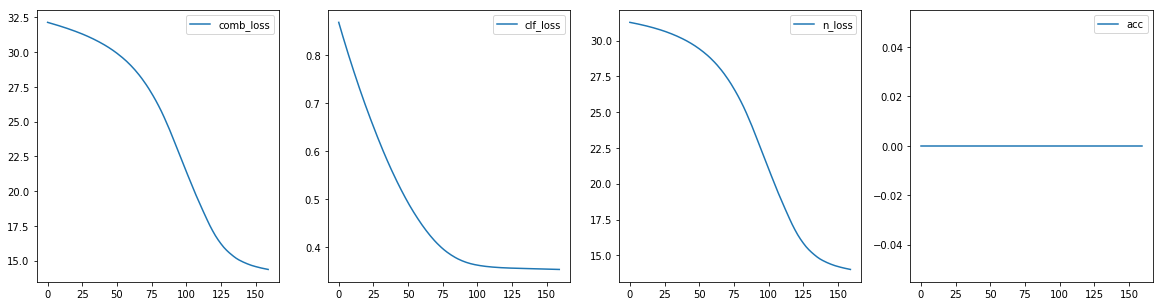

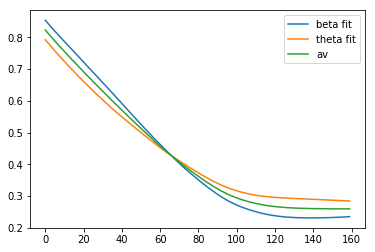

In [39]:
print("elements in h:", len(h))
for tup in h:
    print(tup)

comb_loss, clf_loss, n_loss, acc = zip(*h)


fig = plt.gcf()
#     plt.xlabel("#iterations")
#     plt.ylabel("fit error (RMSE)")
#     plt.suptitle("Neural-MLTM Parameter Fitting")
#     plt.title("(skills=5, items=10, students=100)")
fig, axes = plt.subplots(nrows=1, ncols=4)
axes[0].plot(comb_loss, label="comb_loss")
axes[1].plot(clf_loss, label="clf_loss")
axes[2].plot(n_loss, label="n_loss")
axes[3].plot(acc, label="acc")

fig.set_size_inches(20, 5)
for i in [0,1,2,3]:
    axes[i].legend()
plt.show()

av_fit_rmses = []
for b,th in zip(b_fit_rmses, th_fit_rmses):
    av = (b+th)/2.0
    av_fit_rmses.append(av)
    
plt.plot(b_fit_rmses, label="beta fit")
plt.plot(th_fit_rmses, label="theta fit")
plt.plot(av_fit_rmses, label="av")
plt.legend()
plt.show()
# fig = plt.gcf()
# fig.set_size_inches(8, 5)
# plt.xlabel("#iterations")
# plt.ylabel("fit error (RMSE)")
# plt.suptitle("Neural-MLTM Parameter Fitting")
# plt.title("(skills=5, items=10, students=100)")
# plt.legend()
# plt.show()


In [40]:
real_wgtz = array([ q.betas for q in qs ])
pred_wgtz = q_table.get_weights()[0]
chosen, min_total_err, mean_ll, cos_dis = calc_arr_arr_err(real_wgtz, pred_wgtz, max_iter=10)

print("real", real_wgtz)
# print(pred_wgts)
print("out", chosen)
print("best cos distance:", cos_dis)
print("elementwise mae:", min_total_err)
print("mean lead/lag", mean_ll)

real [[ 0.08695135  0.          2.24661523 ...,  0.89267674  1.7183651
   1.47487956]
 [ 0.          0.26870938  0.         ...,  2.24385199  2.01939344
   2.72157438]
 [ 2.79958944  2.98936053  2.96329512 ...,  3.01115309  1.46526372
   2.83875447]
 ..., 
 [ 0.          0.54469546  0.         ...,  0.88753211  1.91090758  0.        ]
 [ 0.          0.          0.         ...,  0.          0.01117074  0.        ]
 [ 3.07476749  3.0751371   3.06539391 ...,  3.07246306  3.07421298
   3.06875504]]
out [[ 0.          0.          1.67898893 ...,  0.29518339  2.19407749  0.        ]
 [ 0.18725093  0.          1.43470514 ...,  2.11536503  0.          0.05781209]
 [ 1.60163593  2.19096231  2.46107697 ...,  3.07310653  2.95496488
   2.11223841]
 ..., 
 [ 0.57720059  0.73162884  0.89577413 ...,  0.          1.43220198
   0.0901891 ]
 [ 0.44261479  0.78997749  0.44757864 ...,  0.          0.          0.26772282]
 [ 3.046314    3.0751965   3.0751965  ...,  3.0751965   3.0751965
   3.0751965 ]]
bes

In [ ]:
print(itemz.shape)

/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


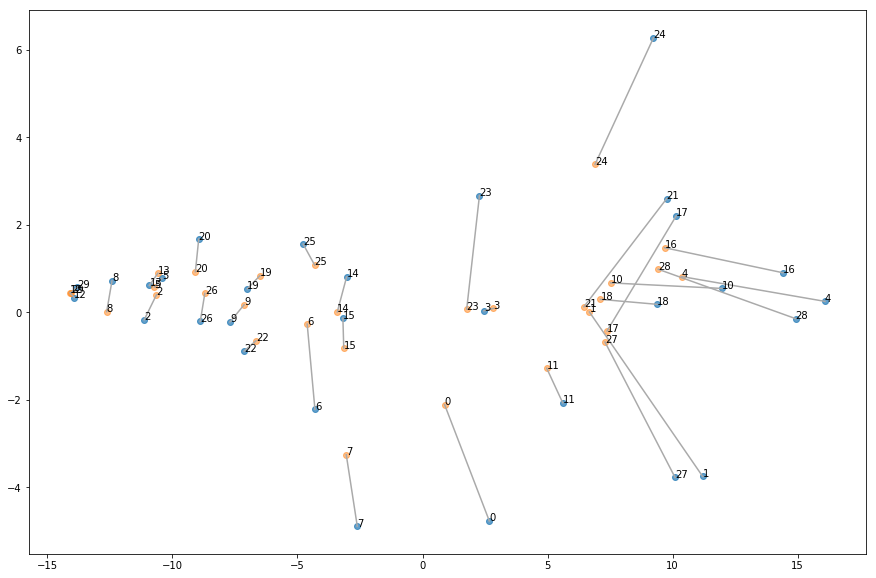

In [36]:
fig = plt.gcf()
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
# pca = TSNE(n_components=2)
# pca2 = TSNE(n_components=2)

itemz = array([ q.betas for q in qs ])

itemz_2 = itemz
itemz_2 = pca.fit_transform(itemz_2)
# itemz_2 = MinMaxScaler().fit_transform(itemz_2)

itemz_pred = chosen
itemz_pred = pca.transform(itemz_pred)
# itemz_pred = MinMaxScaler().fit_transform(itemz_pred)
# print(itemz_2)

# fig,axs = plt.subplots(1,2)
fig = plt.gcf()
fig.set_size_inches(15, 10)

for x,xh,y,yh in zip(itemz_2[:,0],itemz_pred[:,0],itemz_2[:,1],itemz_pred[:,1]):
    fig.gca().plot([x,xh],[y,yh],color="#aaaaaa")

fig.gca().scatter(itemz_2[:,0], itemz_2[:,1], alpha=0.7)
fig.gca().scatter(itemz_pred[:,0], itemz_pred[:,1], alpha=0.5)

for i, txt in enumerate(itemz_2):
    fig.gca().annotate(i, (itemz_2[i,0], itemz_2[i,1]))

for i, txt in enumerate(itemz_pred):
    fig.gca().annotate(i, (itemz_pred[i,0], itemz_pred[i,1]))
    
fig.show()

In [ ]:
psi_wgts = s_table.get_weights()[0]
print(psi_wgts)
for psi in ss:
    print(psi.id, psi.thetas, psi_wgts[psi.id])
print("qs ====")
qn_wgts = q_table.get_weights()[0]
print(qn_wgts)
for qn in qs:
    print(qn.id, qn.betas, qn_wgts[qn.id])

In [ ]:
n_traits = 5
nn_dimensions = [1,3,5,7,9]
serieses = []
min_errs = []
n_qs = 10
n_students = 250
for ix,nnw in enumerate(nn_dimensions):
    qs = create_qs(n_qs, n_traits, nnw, optimiser=qopt)
    ss = create_students(n_students, n_traits, nnw, optimiser=qopt)
    attempts_by_psi, attempts_by_q = generate_attempts(qs,ss)
    print(qs[0].pred_betas.get_weights()[0][0])
    print(ss[0].pred_theta.get_weights()[0][0])
    resultz = calibrate(qs,ss,attempts_by_q, attempts_by_psi, n_iter=70)
    serieses.append( resultz )
#     if ix < len(serieses): #append to old series
#         (_mses,_accs) = serieses[ix]
#         _mses += mses
#         _accs += accs
#         serieuses[ix] = (_mses,_accs)
#     else: #create new series
#         serieses.append((mses,accs))
    
from pygame import mixer
mixer.init()
mixer.music.load('calibration_complete.mp3')
mixer.music.play()

In [ ]:
# import pickle
# pickle.dump( serieses, open( "serieses.p", "wb" ) )

xmax=10
xs = range(len(serieses[0][0]))[0:xmax]
print(len(serieses))
for s in serieses:
    print(len(s))
# plt.plot(xs, numpy.multiply(1,theta_rmses), 'b--')
# plt.plot(xs, numpy.multiply(1,beta_rmses), 'b')
fig, axes = plt.subplots(nrows=3, ncols=2)
print(axes.shape)
for (mses,accs, th_mses,th_accs, b_mses,b_accs),c,d in zip(serieses,["r--","y--","k-","c--","b--"],nn_dimensions):
    axes[0,0].plot(xs, numpy.multiply(1,mses[0:xmax]), c, label="nnw={}".format(d))
    axes[0,1].plot(xs, numpy.multiply(1,accs[0:xmax]), c, label="nnw={}".format(d))
    axes[1,0].plot(xs, numpy.multiply(1,th_mses[0:xmax]), c, label="nnw={}".format(d))
    axes[1,1].plot(xs, numpy.multiply(1,th_accs[0:xmax]), c, label="nnw={}".format(d))
    axes[2,0].plot(xs, numpy.multiply(1,b_mses[0:xmax]), c, label="nnw={}".format(d))
    axes[2,1].plot(xs, numpy.multiply(1,b_accs[0:xmax]), c, label="nnw={}".format(d))

# plt.plot(xs, accs, "m")
# plt.plot(xs, numpy.multiply(1,s_outer_accs), "g")7
# plt.plot(xs, numpy.multiply(1,q_outer_accs), "k")

# plt.plot(xs, numpy.multiply(1,mses), "m--")
# plt.plot(xs, numpy.multiply(1,s_outer_mses), "g--")
# plt.plot(xs, numpy.multiply(1,q_outer_mses), "k--")
for ix in range(axes.shape[0]):
    subcats = ["Combined","Student","Question"]
    for iy in range(axes.shape[1]):
        axes[ix,iy].set_xlabel("#iterations")
        axes[ix,iy].legend()
        if iy==0:
            axes[ix,iy].set_title("{} fit error".format(subcats[ix]))
            axes[ix,iy].set_ylabel("fit error (RMSE)")
        else:
            axes[ix,iy].set_title("{} fit accuracy".format(subcats[ix]))
            axes[ix,iy].set_ylabel("prediction accuracy")

fig.suptitle("Neural-MLTM Parameter Fitting (k={}, q={}, s={})".format(n_traits, n_qs, n_students))
fig.set_size_inches(18, 18)

fig.show()

In [ ]:
xs = range(len(serieses[0][0]))
print(len(serieses))
for s in serieses:
    print(len(s))
# plt.plot(xs, numpy.multiply(1,theta_rmses), 'b--')
# plt.plot(xs, numpy.multiply(1,beta_rmses), 'b')
fig, axes = plt.subplots(nrows=1, ncols=2)
print(axes.shape)

min_mses = []
max_accs = []
bmin_mses = []
bmax_accs = []

for (mses,accs, th_mses,th_accs, b_mses,b_accs),c,d in zip(serieses,["r--","y--","k-","c--","b--"],nn_dimensions):
    mm = min(th_mses)
    ma = max(th_accs)
    min_mses.append(mm)
    max_accs.append(ma)
    mm = min(b_mses)
    ma = max(b_accs)
    bmin_mses.append(mm)
    bmax_accs.append(ma)
    

axes[0].plot(nn_dimensions, numpy.multiply(1,min_mses))
axes[0].plot(nn_dimensions, numpy.multiply(1,bmin_mses))
axes[1].plot(nn_dimensions, numpy.multiply(1,max_accs))
axes[1].plot(nn_dimensions, numpy.multiply(1,bmax_accs))
axes[0].axvline(x=5, linestyle="--")
axes[1].axvline(x=5, linestyle="--")

fig.suptitle("Neural-MLTM Parameter Fitting (k={}, q={}, s={})".format(n_traits, n_qs, n_students))
fig.set_size_inches(18,4)

fig.show()